# Large scale text analysis with deep learning (3 points)

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [1]:
%pip install pandas matplotlib torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [3]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [4]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

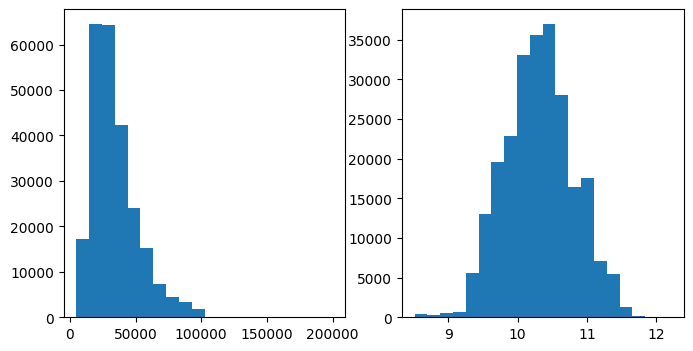

In [5]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
29678,68056697,Business Development Executive,Business Development Lead Generation in IT / T...,"Slough, Berkshire Berkshire South East",Slough,NaN,permanent,New Business People Ltd,Sales Jobs,"From 20,000 to 28,000 per annum + Excellent be...",24000,totaljobs.com,10.085851
144349,70651462,Regional Front of House Manager Corporate Ser...,Regional Front of House Manager Corporate Ser...,"UK, Greater London",London,NaN,NaN,Hamilton Mayday,Hospitality & Catering Jobs,35000 per annum + benefits,35000,jobs.catererandhotelkeeper.com,10.463132
50175,68630611,GRADUATE SALES EXECUTIVE,GRADUATE SALES EXECUTIVESector: Domestic House...,North West,North West London,NaN,permanent,NaN,Sales Jobs,20k - 25k,22500,simplysalesjobs.co.uk,10.021315


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [7]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [8]:
import nltk

#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

def formatText(text: str):
    if not isinstance(text, str):
        return ''
        
    tokens = tokenizer.tokenize(text)
    return ' '.join(tokens).lower()

data.Title = data.Title.map(formatText)

data.FullDescription = data.FullDescription.map(formatText)


Now we can assume that our text is a space-separated list of tokens:

In [9]:
print("Tokenized:")
print(data["FullDescription"][2::100000])

print(data["FullDescription"][2][:50])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'

print(data["Title"][54321])
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object
mathematical modeller / simulation analyst / opera
international digital account manager ( german )


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [10]:
from collections import Counter

# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>
token_counts = Counter()

for title in data["Title"].values:
    for token in title.split(' '):
        token_counts[token] += 1
        
for description in data["FullDescription"].values:
    for token in description.split(' '):
        token_counts[token] += 1

# token_counts = Counter(np.add.reduce(data["Title"]) + np.add.reduce(data["FullDescription"]))

In [11]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202705
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


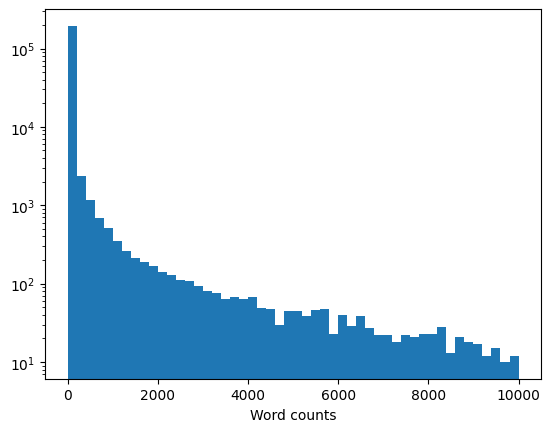

In [12]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [14]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
token_to_id = {} #<your code here - dict of token name to its index in tokens>

for i, token in enumerate(tokens):
    token_to_id[token] = i

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [18]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [19]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [20]:
print(categorical_vectorizer.vocabulary_)

{'Category=Accounting & Finance Jobs': 0, 'Category=Admin Jobs': 1, 'Category=Charity & Voluntary Jobs': 2, 'Category=Consultancy Jobs': 3, 'Category=Creative & Design Jobs': 4, 'Category=Customer Services Jobs': 5, 'Category=Domestic help & Cleaning Jobs': 6, 'Category=Energy, Oil & Gas Jobs': 7, 'Category=Engineering Jobs': 8, 'Category=Graduate Jobs': 9, 'Category=HR & Recruitment Jobs': 10, 'Category=Healthcare & Nursing Jobs': 11, 'Category=Hospitality & Catering Jobs': 12, 'Category=IT Jobs': 13, 'Category=Legal Jobs': 14, 'Category=Logistics & Warehouse Jobs': 15, 'Category=Maintenance Jobs': 16, 'Category=Manufacturing Jobs': 17, 'Category=Other/General Jobs': 18, 'Category=PR, Advertising & Marketing Jobs': 19, 'Category=Part time Jobs': 20, 'Category=Property Jobs': 21, 'Category=Retail Jobs': 22, 'Category=Sales Jobs': 23, 'Category=Scientific & QA Jobs': 24, 'Category=Social work Jobs': 25, 'Category=Teaching Jobs': 26, 'Category=Trade & Construction Jobs': 27, 'Category=Tr

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [21]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [23]:
batch = make_batch(data_train[:3], max_len=10)
batch

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]]),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [42]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 64
N_TOKENS = len(tokens)
N_CATEGORICAL_FEATURES=len(categorical_vectorizer.vocabulary_)
N_CATEGORICAL_FEATURES

3768

In [24]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding = torch.nn.Embedding(N_TOKENS, EMBEDDING_DIM)
        self.convolution = torch.nn.Conv1d(EMBEDDING_DIM, HIDDEN_DIM, kernel_size=3)
        
    def forward(self, batch):
        embeddings = self.embedding(batch)
        # torch.Size([100, 17, 32])
        # torch.Size([titles amount, title length, embedding_dim])
        
        # почему так можно делать?
        # теряется "физический смысл": 100 тайтлов, каждый представлен как 17 эмбеддинггов по 32
        # с точки зрения МЛ всё равно?
        # может, будем учитвать это транспонирование на выходе?
        embeddings = embeddings.transpose(2, 1)
        # torch.Size([100, 32, 17])
        
        convolution_outs = self.convolution(embeddings)
        # torch.Size([100, 64, 15])
        # torch.Size([100, 64, amount of kernel_size frames in 17])
        
        max_pool = torch.max(convolution_outs, dim=-1).values
        # torch.Size([100, 64])
        # уменьшилась мерность, потому что max выбирает по одному из вектора
        
        return max_pool

In [126]:
class SalaryPredictor(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.with_batch_norm = kwargs.get('with_batch_norm') or False
        self.with_dropout = kwargs.get('with_dropout') or False
        
        print(f'with_batch_norm: {self.with_batch_norm}')
        print(f'with_dropout: {self.with_dropout}')
        
        self.title_encoder = TextEncoder()
        self.description_encoder = TextEncoder()
        self.categorical_embedding_encoder = nn.Linear(N_CATEGORICAL_FEATURES, EMBEDDING_DIM)
        self.batch_norm = nn.BatchNorm1d(HIDDEN_DIM + HIDDEN_DIM + EMBEDDING_DIM)
        self.dropout = nn.Dropout(0.1)
        self.fully_connected_1 = nn.Linear(HIDDEN_DIM + HIDDEN_DIM + EMBEDDING_DIM, HIDDEN_DIM)
        self.fully_connected_2 = nn.Linear(HIDDEN_DIM, 1)
        
        
    def forward(self, batch):
        # torch.Size([100, 64])
        title_out = self.title_encoder(batch['Title'])
        
        # torch.Size([100, 64])
        description_out = self.description_encoder(batch['FullDescription'])
        
        # C) Fun with words: Use the same embedding matrix in title and desc vectorizer
        self.description_encoder.embedding = self.title_encoder.embedding
        
        # torch.Size([100, 32])
        categorical_embedding = self.categorical_embedding_encoder(batch['Categorical'])
        
        # torch.Size([100, 160])
        x = torch.cat([title_out, description_out, categorical_embedding], dim=1)
        
        if self.with_batch_norm:
            x = self.batch_norm(x)
        
        if self.with_dropout:
            x = self.dropout(x)
        
        # torch.Size([100, 64])
        x = self.fully_connected_1(x)
        
        # torch.Size([100, 1])
        x = self.fully_connected_2(x)
        
        # torch.Size([100])
        return x.flatten()

In [115]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])

assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

with_batch_norm: False
with_dropout: False


#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [89]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [131]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

In [125]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [92]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')

parameters = model.parameters()
print(f'parameters: {[p for p in model.parameters()]}')

optimizer = torch.optim.SGD(parameters, lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

      

parameters: [Parameter containing:
tensor([[-1.2908, -1.0832, -1.0623,  ...,  0.2238,  0.2119,  0.7682],
        [ 2.7092,  1.5776,  0.7099,  ...,  0.0269, -2.1735,  0.3122],
        [-1.1969,  0.4750, -0.4251,  ..., -0.9623,  1.6217, -1.0861],
        ...,
        [-0.6904,  0.2216, -1.0652,  ...,  1.3131,  0.6423,  0.3684],
        [ 0.7309,  0.3019, -1.7700,  ...,  0.3361,  0.5784,  0.1891],
        [ 0.1326, -0.1758,  1.4840,  ..., -1.6584, -0.5925,  0.8953]],
       requires_grad=True), Parameter containing:
tensor([[[-0.0267, -0.0626, -0.0417],
         [-0.0774, -0.0954, -0.0851],
         [ 0.0142, -0.0707,  0.0528],
         ...,
         [ 0.0466,  0.0481, -0.0796],
         [-0.0437,  0.0344,  0.0709],
         [ 0.0662,  0.0701,  0.0889]],

        [[ 0.0709, -0.0071,  0.0875],
         [ 0.0413,  0.0730,  0.0533],
         [-0.0219,  0.0243,  0.0616],
         ...,
         [ 0.0134,  0.0126,  0.1009],
         [-0.0779,  0.0893,  0.0918],
         [-0.0520,  0.0955, -0.03

12239it [06:13, 32.75it/s]                           


 results:
Mean square error: 0.17462
Mean absolute error: 0.33163
epoch: 1


12239it [06:08, 33.17it/s]                           


 results:
Mean square error: 0.14101
Mean absolute error: 0.29445
epoch: 2


12239it [06:05, 33.51it/s]                           


 results:
Mean square error: 0.12984
Mean absolute error: 0.28125
epoch: 3


12239it [06:00, 33.95it/s]                           


 results:
Mean square error: 0.11768
Mean absolute error: 0.26559
epoch: 4


12239it [06:01, 33.89it/s]                           


 results:
Mean square error: 0.10625
Mean absolute error: 0.24813


In [133]:
def train_model(model):
    model = model.to(device)
    criterion = nn.MSELoss(reduction='sum')

    parameters = model.parameters()
    # print(f'parameters: {[p for p in model.parameters()]}')

    optimizer = torch.optim.SGD(parameters, lr=1e-4)

    train_mae_per_epoch = []
    val_mae_per_epoch = []
    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")
        model.train()
        abs_error = num_samples = 0.0
        
        for i, batch in tqdm(enumerate(
                iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
                total=len(data_train) // BATCH_SIZE
            ):
            pred = model(batch)
            training_loss = criterion(pred, batch[TARGET_COLUMN])
            num_samples += len(pred)
            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()
            
        train_mse, train_mae = print_metrics(model, data_train, device=device, name='train')
        val_mse, val_mae = print_metrics(model, data_val, device=device, name='val')
        
        train_mae_per_epoch.append(train_mae)
        val_mae_per_epoch.append(val_mae)
        
    plt.plot(train_mae_per_epoch, label='train_mae')
    plt.plot(val_mae_per_epoch,label='val_mae')
    plt.legend()
    plt.show

with_batch_norm: True
with_dropout: False
epoch: 0


12239it [06:10, 33.02it/s]                           


 results:
Mean square error: 0.13259
Mean absolute error: 0.28127
 results:
Mean square error: 0.13170
Mean absolute error: 0.28043
epoch: 1


12239it [38:07,  5.35it/s]                               


 results:
Mean square error: 0.12515
Mean absolute error: 0.27170
 results:
Mean square error: 0.12469
Mean absolute error: 0.27223


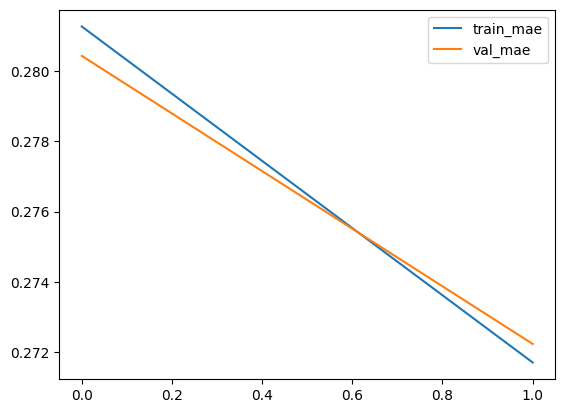

In [129]:

model_with_batch_norm = SalaryPredictor(with_batch_norm=True)
train_model(model_with_batch_norm)

with_batch_norm: True
with_dropout: True
epoch: 0


12239it [06:01, 33.90it/s]                           


train_mae results:
Mean square error: 0.15222
Mean absolute error: 0.30126
val_mae results:
Mean square error: 0.15124
Mean absolute error: 0.30187
epoch: 1


12239it [06:05, 33.49it/s]                           


train_mae results:
Mean square error: 0.12961
Mean absolute error: 0.27816
val_mae results:
Mean square error: 0.12932
Mean absolute error: 0.27842
epoch: 2


12239it [06:02, 33.79it/s]                           


train_mae results:
Mean square error: 0.12787
Mean absolute error: 0.27367
val_mae results:
Mean square error: 0.12766
Mean absolute error: 0.27446
epoch: 3


12239it [06:37, 30.77it/s]                           


train_mae results:
Mean square error: 0.11394
Mean absolute error: 0.25723
val_mae results:
Mean square error: 0.11485
Mean absolute error: 0.25957
epoch: 4


12239it [06:36, 30.86it/s]                           


train_mae results:
Mean square error: 0.11463
Mean absolute error: 0.26086
val_mae results:
Mean square error: 0.11558
Mean absolute error: 0.26310


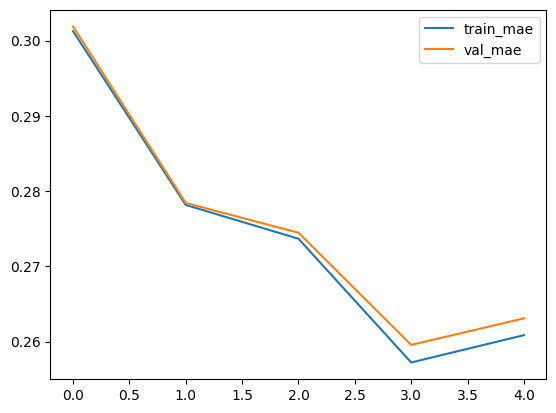

In [134]:
model_with_dropout = SalaryPredictor(with_batch_norm=True, with_dropout=True)
train_model(model_with_dropout)

### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [135]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [136]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [137]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [138]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

RuntimeError: Calculated padded input size per channel: (2). Kernel size: (3). Kernel size can't be greater than actual input size

In [139]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 76002


RuntimeError: Calculated padded input size per channel: (2). Kernel size: (3). Kernel size can't be greater than actual input size

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)